# Notebook for phase two

## Building an ensemble using pre-trained models

Here we construct an ensemble, with the use case of predicting for new stations

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Define some functions

- replace_nan fills NaN values with column means. We don't use it but it was useful for exploratory analysis
- show_nans is also for exploration
- convert_weekdays moves weekday strings into integers from one to seven
- score_abs_error takes a model with SKLEARN syntax and used it to predict the number of bikes based on input data, then return the mean absolute error. round_ specifies whether output should be rounded to integers.
- reasonable_predictions is a bit redundant, taking a model and data and predicting


In [3]:
# Adding all files into one DataFrame
# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7], inplace=True)


df = []
for path in Path('./Train/Train').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
    # show_nans(tmp)
    #replace_nan(tmp)
    tmp = tmp.dropna(axis='rows')
    df.append(tmp)

df = pd.concat(df, ignore_index=True)

convert_weekdays(df)

x = df.iloc[:,:-1].to_numpy()
y = df['bikes'].to_numpy()

## Build linear models

This cell reads all of the model files and uses the values in each to build an sklearn linear regressor

This lets us use the simple APIs of sklearn instead of uncessarily coding our own

It also uses the data from the previous cell to measure the validation error of each model

In [7]:
# Adding all files into one DataFrame
all_columns = list(df.columns)

models = []
errors = []

for path in Path('./Models/Models').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
    # show_nans(tmp)
    #replace_nan(tmp)
    tmp = tmp.dropna(axis='rows')
    features = tmp['feature']
    weights = tmp['weight']
    
    weight_based = np.zeros((1, len(all_columns)))
    model_frame = pd.DataFrame(data=weight_based, columns=all_columns)
    
    for i, f in enumerate(features):
        model_frame[f] = weights[i]
    
    # removing intercept and bikes
    final_weights = model_frame.iloc[0,:-2].to_numpy()
    
    intercept = model_frame.iloc[0,-1]
    
    model = linear_model.LinearRegression()
    model.coef_ = final_weights
    model.intercept_ = intercept    
    
    models.append(model)
    
    y_pred = model.predict(x)
    errors.append(mean_absolute_error(y, y_pred))
    # print(final_weights)
    # print(intercept)

(array([206., 301., 209., 131.,  87.,  65.,  34.,  42.,  29.,  21.,   9.,
         15.,   5.,  10.,   6.,   6.,   6.,   4.,   0.,   6.,   0.,   0.,
          0.,   0.,   6.,   0.,   0.,   0.,   0.,   2.]),
 array([2.65554842, 2.68152072, 2.70749302, 2.73346532, 2.75943762,
        2.78540992, 2.81138222, 2.83735452, 2.86332682, 2.88929913,
        2.91527143, 2.94124373, 2.96721603, 2.99318833, 3.01916063,
        3.04513293, 3.07110523, 3.09707753, 3.12304983, 3.14902213,
        3.17499443, 3.20096673, 3.22693903, 3.25291133, 3.27888363,
        3.30485593, 3.33082823, 3.35680053, 3.38277283, 3.40874513,
        3.43471743]),
 <BarContainer object of 30 artists>)

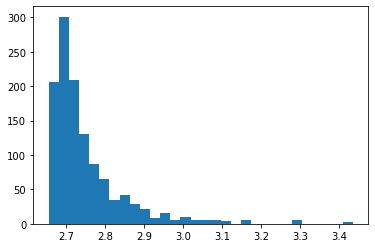

In [10]:
plt.hist(errors, bins=30)

1.0


(array([  2.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   5.,   1.,   4.,
          6.,   5.,   7.,  10.,   3.,  15.,   9.,  17.,  18.,  40.,  32.,
         43.,  58.,  72., 105., 138., 223., 226., 155.]),
 array([0.00066659, 0.00067311, 0.00067963, 0.00068615, 0.00069267,
        0.00069919, 0.00070571, 0.00071222, 0.00071874, 0.00072526,
        0.00073178, 0.0007383 , 0.00074482, 0.00075134, 0.00075786,
        0.00076438, 0.0007709 , 0.00077742, 0.00078394, 0.00079046,
        0.00079698, 0.0008035 , 0.00081002, 0.00081654, 0.00082306,
        0.00082958, 0.0008361 , 0.00084261, 0.00084913, 0.00085565,
        0.00086217]),
 <BarContainer object of 30 artists>)

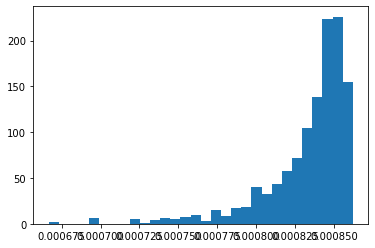

In [12]:
model_weights = np.array(errors)
model_weights = 1 / model_weights
model_weights = model_weights / np.sum(model_weights)
# should equal 1
print(np.sum(model_weights))

plt.hist(model_weights, bins=30)

In [17]:
def ensemble_predict(models, model_weights, x):
    results = np.zeros(x.shape[0])
    
    for i, m in enumerate(models):
        results = results + m.predict(x) * model_weights[i]

    return results

y_pred = ensemble_predict(models, model_weights, x)

mean_absolute_error(y, y_pred)

2.661009517493196

(array([4.0000e+00, 6.0000e+00, 2.0000e+00, 1.1000e+01, 2.0000e+01,
        1.8000e+01, 8.0000e+01, 1.5500e+02, 3.6800e+02, 8.6100e+02,
        1.9020e+03, 4.1780e+03, 9.1370e+03, 1.2624e+04, 7.0290e+03,
        3.2590e+03, 1.5900e+03, 7.0800e+02, 3.4300e+02, 1.6100e+02,
        7.1000e+01, 4.0000e+01, 1.8000e+01, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-26.81066715, -24.8019345 , -22.79320184, -20.78446919,
        -18.77573653, -16.76700388, -14.75827123, -12.74953857,
        -10.74080592,  -8.73207326,  -6.72334061,  -4.71460796,
         -2.7058753 ,  -0.69714265,   1.31159001,   3.32032266,
          5.32905531,   7.33778797,   9.34652062,  11.35525328,
         13.36398593,  15.37271858,  17.38145124,  19.39018389,
         21.39891655,  23.4076492 ,  25.41638185,  27.42511451,
         29.43384716,  31.44257982,  33.45131247]),
 <BarContainer object of 30 artists>)

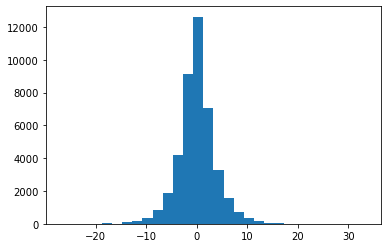

In [19]:
plt.hist(y - y_pred, bins=30)